In [1]:
import os

from PIL import Image
import numpy as np
import openslide
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import multiprocessing
from io import BytesIO
from pathlib import Path
import pandas as pd
import time
from concurrent.futures import ThreadPoolExecutor
import csv


%load_ext autoreload
%autoreload 2


Min_SIZE_MB = 13.5  # Taille max par tuile (en Mo)
tile_size_l = 4096
tile_size_h = 2048  # Taille des tuiles
level = 0  # Niveau de zoom OpenSlide (0 = max résolution)
train_tumor_path = "/mnt/c/Users/grego/Documents/Projet_ML/Data/Dataset/train/tumor"
train_normal_path = "/mnt/c/Users/grego/Documents/Projet_ML/Data/Dataset/train/normal"
treated_tumor_path='/mnt/c/Users/grego/Documents/Projet_ML/Data/TREATED/tumor'
treated_normal_path='/mnt/c/Users/grego/Documents/Projet_ML/Data/TREATED/normal'
totreat_tumor_path = '/mnt/c/Users/grego/Documents/Projet_ML/Data/TOTREAT/tumor'
totreat_normal_path = '/mnt/c/Users/grego/Documents/Projet_ML/Data/TOTREAT/normal'

os.environ["OMP_NUM_THREADS"] = "16"  # Ajustez selon votre nombre de cœurs
os.environ["MKL_NUM_THREADS"] = "16"
input_path = "/mnt/c/Users/grego/Documents/Projet_ML/Data/TOTREAT/tumor" # / a la fin
val_path='/mnt/c/Users/grego/Documents/Projet_ML/Data/Dataset/val'
train_path='/mnt/c/Users/grego/Documents/Projet_ML/Data/Dataset/train'

In [5]:
from pathlib import Path
listfile = list(Path(train_normal_path).glob('*.png'))
len(listfile)

826

In [4]:
listfile.name.split(sep="_")[1]

AttributeError: 'list' object has no attribute 'name'

In [ ]:
import os
import re
import random

def select_random_files_by_index(directory, num_files=15):
    """
    Sélectionne aléatoirement un certain nombre de fichiers ayant le même indice.

    Args:
        directory (str): Chemin vers le répertoire contenant les fichiers
        num_files (int): Nombre de fichiers à sélectionner (défaut: 5)

    Returns:
        list: Liste des fichiers sélectionnés
    """
    all_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    # Extraire les indices des fichiers
    indices = {}
    for filename in all_files:
        # Utiliser une expression régulière pour extraire l'indice
        match = re.search(r'tile_([a-zA-Z0-9]+)_', filename)
        if match:
            index = match.group(1)
            if index not in indices:
                indices[index] = []
            indices[index].append(filename)
    print(indices)
    # Dictionnaire pour stocker les résultats
    selected_files_by_index = {}

    # Pour chaque indice, sélectionner des fichiers aléatoires
    for index, files in indices.items():
        # Si suffisamment de fichiers sont disponibles pour cet indice
        if len(files) >= num_files:
            # Si suffisamment de fichiers sont disponibles, en sélectionner 5 aléatoirement
            selected_files_by_index[index] = random.sample(files, num_files)
        else:
            # Si moins de 5 fichiers sont disponibles, prendre tous les fichiers
            selected_files_by_index[index] = files

    return selected_files_by_index

# Exemple d'utilisation
if __name__ == "__main__":
    directory_path = train_normal_path  # Remplacez par votre chemin
    selected_normal_files = select_random_files_by_index(directory_path)

    print(f"Fichiers sélectionnés avec le même indice:")
    for indice, file in selected_normal_files.items():
        print(f"{indice} : {file}")

{'02228': ['tile_02228_c132_r10_c2.png', 'tile_02228_c132_r10_c3.png', 'tile_02228_c132_r1_c5.png', 'tile_02228_c132_r2_c6.png', 'tile_02228_c132_r3_c6.png'], '02229': ['tile_02229_c288_r10_c36.png', 'tile_02229_c288_r10_c37.png', 'tile_02229_c288_r10_c38.png', 'tile_02229_c288_r12_c21.png', 'tile_02229_c288_r15_c40.png', 'tile_02229_c288_r15_c44.png', 'tile_02229_c288_r16_c31.png', 'tile_02229_c288_r6_c36.png', 'tile_02229_c288_r6_c4.png', 'tile_02229_c288_r7_c35.png', 'tile_02229_c288_r7_c36.png', 'tile_02229_c288_r8_c36.png', 'tile_02229_c288_r8_c41.png', 'tile_02229_c288_r9_c36.png', 'tile_02229_c288_r9_c37.png', 'tile_02229_c288_r9_c43.png', 'tile_02229_c66_r0_c0.png', 'tile_02229_c89_r0_c0.png'], '02230': ['tile_02230_c103_r10_c0.png', 'tile_02230_c103_r10_c1.png', 'tile_02230_c103_r1_c6.png', 'tile_02230_c103_r1_c7.png', 'tile_02230_c103_r5_c8.png', 'tile_02230_c103_r5_c9.png', 'tile_02230_c103_r6_c7.png', 'tile_02230_c103_r6_c8.png', 'tile_02230_c103_r6_c9.png', 'tile_02230_c10

In [59]:
pd.DataFrame(selected_normal_files.keys())

,0
0,02228
1,02229
2,02230
3,02231
4,02232
5,02233
6,02234
7,02235
8,02236
9,02237


In [38]:
all_files = [f for f in os.listdir(train_tumor_path) if os.path.isfile(os.path.join(train_tumor_path, f))]
all_files.remove('all_tiles_coordinates.csv')
all_files.remove('label_tumor.csv')
all_files


['tile_01092_c156_r5_c2.png',
 'tile_01092_c324_r0_c0.png',
 'tile_01092_c333_r2_c1.png',
 'tile_01092_c333_r4_c2.png',
 'tile_01092_c66_r1_c1.png',
 'tile_02100_c209_r0_c0.png',
 'tile_02100_c298_r0_c0.png',
 'tile_02100_c579_r0_c0.png',
 'tile_02100_c58_r0_c0.png',
 'tile_02100_c604_r0_c0.png',
 'tile_02102_c252_r1_c3.png',
 'tile_02102_c31_r0_c0.png',
 'tile_02102_c34_r0_c0.png',
 'tile_02102_c400_r0_c0.png',
 'tile_02102_c74_r1_c2.png',
 'tile_02104_c196_r0_c0.png',
 'tile_02104_c78_r0_c0.png',
 'tile_02104_c79_r0_c0.png',
 'tile_02104_c85_r0_c0.png',
 'tile_02104_c9_r0_c0.png',
 'tile_02106_c138_r1_c1.png',
 'tile_02106_c299_r4_c4.png',
 'tile_02106_c572_r4_c8.png',
 'tile_02106_c685_r2_c6.png',
 'tile_02106_c831_r2_c4.png',
 'tile_02108_c139_r0_c0.png',
 'tile_02108_c148_r3_c3.png',
 'tile_02108_c364_r4_c12.png',
 'tile_02108_c364_r5_c4.png',
 'tile_02108_c88_r4_c6.png',
 'tile_02110_c284_r4_c4.png',
 'tile_02110_c305_r1_c8.png',
 'tile_02110_c306_r1_c2.png',
 'tile_02110_c504_r5

In [32]:
!pip install natsort


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
from natsort import natsort_keygen
result = pd.DataFrame(all_files).rename(columns={0: 'fichier'})
result = result.sort_values('fichier', key=natsort_keygen())
result
result['lame']=result['fichier'].apply(lambda x: x.split(sep='_')[1])
result['tx_c_t'] = "TBD"
result['label'] = "TBD"

result


,fichier,lame,tx_c_t,label
4,tile_01092_c66_r1_c1.png,01092,TBD,TBD
0,tile_01092_c156_r5_c2.png,01092,TBD,TBD
1,tile_01092_c324_r0_c0.png,01092,TBD,TBD
2,tile_01092_c333_r2_c1.png,01092,TBD,TBD
3,tile_01092_c333_r4_c2.png,01092,TBD,TBD
...,...,...,...,...
295,tile_RB02158_c85_r0_c0.png,RB02158,TBD,TBD
296,tile_RB02158_c91_r1_c3.png,RB02158,TBD,TBD
297,tile_RB02158_c91_r2_c2.png,RB02158,TBD,TBD
298,tile_RB02158_c91_r2_c3.png,RB02158,TBD,TBD


In [51]:
result.to_csv(f"{train_tumor_path}/label_tumor2.csv")

In [ ]:
import random
import shutil
def move_unselected_files(directory, selected_files_dict):
    """
    Déplace les fichiers non sélectionnés vers un répertoire 'noselect'.

    Args:
        directory (str): Chemin vers le répertoire contenant les fichiers
        selected_files_dict (dict): Dictionnaire des fichiers sélectionnés par indice

    Returns:
        int: Nombre de fichiers déplacés
    """
    # Créer une liste de tous les fichiers sélectionnés
    all_selected_files = []
    for files in selected_files_dict.values():
        all_selected_files.extend(files)

    # Liste tous les fichiers dans le répertoire
    all_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    # Créer le répertoire 'noselect' s'il n'existe pas
    noselect_dir = os.path.join(directory, "noselect")
    if not os.path.exists(noselect_dir):
        os.makedirs(noselect_dir)

    # Déplacer les fichiers non sélectionnés vers le répertoire 'noselect'
    files_moved = 0
    for filename in all_files:
        # Vérifier si le fichier contient un indice (pour éviter de déplacer des fichiers non pertinents)
        if re.search(r'tile_(\d+)_', filename):
            if filename not in all_selected_files:
                source_path = os.path.join(directory, filename)
                target_path = os.path.join(noselect_dir, filename)
                shutil.move(source_path, target_path)
                files_moved += 1

    return files_moved


In [7]:
files

'tile_02104_c196_r0_c0.png'

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
from anapath.lib import who_am_i

ImportError: cannot import name 'who_am_i' from 'anapath.lib' (/home/gregoire/.pyenv/versions/3.10.6/envs/anapath/lib/python3.10/site-packages/anapath/lib.py)

In [13]:
import sys
print(sys.path)  # Vérifier que le chemin contenant anapath est bien là

['/home/gregoire/code/Greg-hub-dev/projet-anapath/anapath/notebooks', '/home/gregoire/code/Greg-hub-dev/04-Decision-Science/01-Project-Setup/data-context-and-setup', '/home/gregoire/code/Greg-hub-dev/projet-anapath/anapath/notebooks', '/home/gregoire/.pyenv/versions/3.10.6/lib/python310.zip', '/home/gregoire/.pyenv/versions/3.10.6/lib/python3.10', '/home/gregoire/.pyenv/versions/3.10.6/lib/python3.10/lib-dynload', '', '/home/gregoire/.pyenv/versions/3.10.6/envs/anapath/lib/python3.10/site-packages', '/home/gregoire/code/Greg-hub-dev/projet-anapath']


In [16]:
import anapath
from anapath import anapath.image.manip
filepath = f"{train_tumor_path}/tile_02104_c196_r0_c0.png"

image = load_tif_image(filepath)

SyntaxError: invalid syntax (2849036740.py, line 2)

In [ ]:
filepath = f"{train_tumor_path}/tile_02102_c74_r1_c2.png"
image = Image.open(filepath)
img1 = np.array(image)
img1.shape

from sklearn.cluster import KMeans

X = img1.reshape(-1,4)
X.shape
km = KMeans(n_clusters=5).fit(X)
segmented_img = km.cluster_centers_[km.labels_]
segmented_img = segmented_img.reshape(img1.shape)


(2048, 4096, 4)

In [4]:
from sklearn.cluster import KMeans

X = img1.reshape(-1,4)
X.shape
km = KMeans(n_clusters=5).fit(X)
segmented_img = km.cluster_centers_[km.labels_]
segmented_img = segmented_img.reshape(img1.shape)

km.score


/home/gregoire/.pyenv/versions/3.10.6/envs/anapath/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<bound method _BaseKMeans.score of KMeans(n_clusters=5)>

In [3]:
np.round(km.cluster_centers_)


NameError: name 'np' is not defined

In [ ]:
filepath = f"{train_tumor_path}/tile_02102_c74_r1_c2.png"
image = Image.open(filepath)
img1 = np.array(image)
img1.shape

from sklearn.cluster import KMeans

X = img1.reshape(-1,4)
X.shape
km = KMeans(n_clusters=5).fit(X)
segmented_img = km.cluster_centers_[km.labels_]
segmented_img = segmented_img.reshape(img1.shape)


True

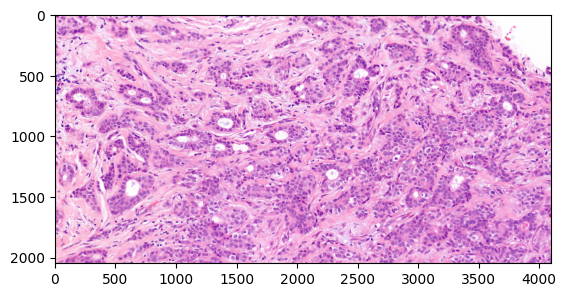

In [68]:
plt.imshow(img1)
cv2.imwrite("resultat_rgba_3.jpg", img1)

In [2]:
import anapath.image

ModuleNotFoundError: No module named 'anapath.image'

(2048, 4096, 4)

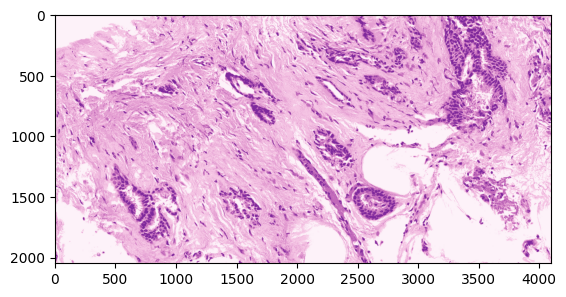

In [7]:
segmented_img_int = np.round(segmented_img).astype(np.int32)
plt.imshow(segmented_img_int)
segmented_img_int.shape

In [41]:
image_process = image_test_rgba[:, :, :3].copy()
image_process = image_process.astype(np.uint8)
image_contour = cv2.cvtColor(image_process, cv2.COLOR_RGB2BGR)

In [58]:
km.cluster_centers_

array([[251.24383406, 226.86252314, 241.41538778, 255.        ],
       [149.96871891,  61.61686425, 178.52243638, 255.        ],
       [224.97097486, 148.69809587, 210.69035601, 255.        ],
       [243.9850532 , 183.98656726, 224.26177918, 255.        ],
       [189.76117731, 108.09418521, 195.60614467, 255.        ]])


=== Exemple 2: Image RGBA ===
Nombre total de points détectés: 2395
Taille moyenne des points: 1035.87 pixels
Taille minimale: 8.00 pixels
Taille maximale: 100436.50 pixels


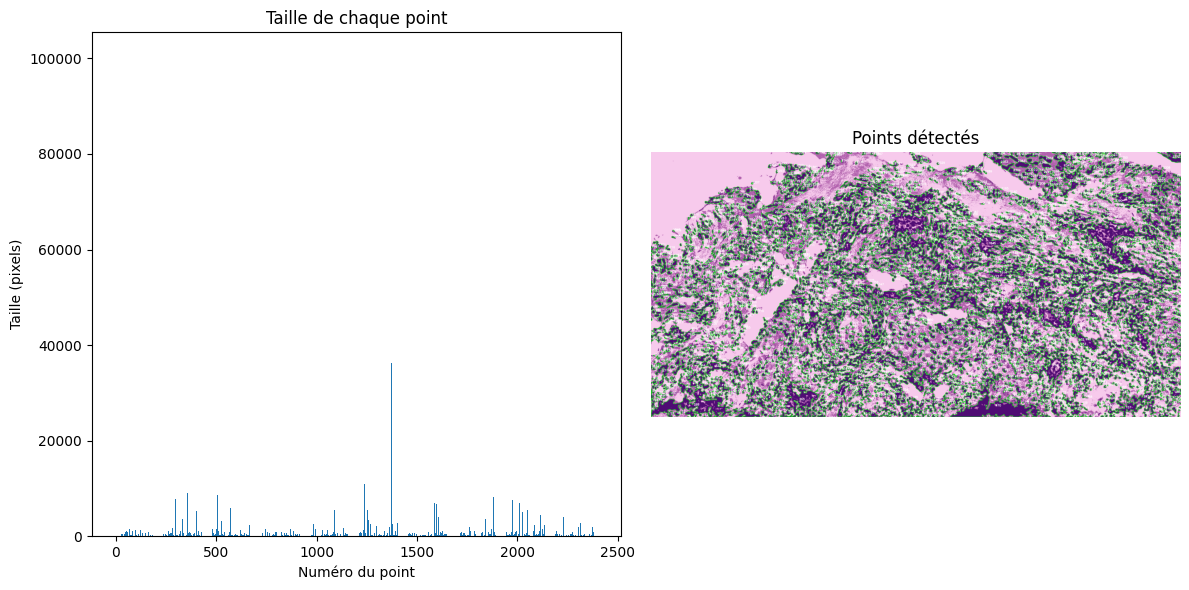

le taux de cellule cancéreuse est de : taille    39.582463
dtype: float64


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compter_points_colores(image, couleur_cible, tolerance=0, alpha_min=0):
    """
    Compte les points d'une couleur spécifique dans une image et calcule leur taille.
    Supporte les images RGB, BGR et RGBA.

    Args:
        image: Peut être soit un chemin vers l'image (str) soit un tableau NumPy (np.array)
        couleur_cible (tuple): Couleur à rechercher au format BGR ou RGB selon le format de l'image
        tolerance (int): Tolérance pour la détection de couleur
        alpha_min (int): Valeur minimale du canal alpha à considérer (0-255, 0 = ignorer l'alpha)

    Returns:
        tuple: (nombre de points, liste des tailles en pixels, image avec contours)
    """
    # Vérifier si l'entrée est un chemin ou un tableau NumPy
    #if isinstance(image, str):
    #    # Charger l'image depuis le chemin avec le canal alpha si disponible
    #    image = cv2.imread(image, cv2.IMREAD_UNCHANGED)
    #    if image is None:
    #        raise ValueError(f"Impossible de charger l'image: {image}")
    #elif not isinstance(image, np.ndarray):
    #    raise TypeError("L'image doit être soit un chemin (str) soit un tableau NumPy (np.array)")

    # Créer une copie pour le dessin des contours et préparer l'image pour la détection
    original_shape = image.shape
    has_alpha = len(original_shape) == 3 and original_shape[2] == 4

    # Gérer les différents formats d'image
    if has_alpha:
        # Image RGBA: extraire le canal alpha et convertir en BGR pour traitement
        alpha_channel = image[:, :, 3]
        image_process = image[:, :, :3].copy()


        # Créer une version BGR pour le dessin
        if alpha_min > 0:
            # Créer un masque pour les pixels avec alpha suffisant
            alpha_mask = alpha_channel >= alpha_min
            # Convertir le masque en 3 canaux pour l'utiliser avec l'image
            alpha_mask_3d = np.stack([alpha_mask] * 3, axis=2)
        else:
            # Si on ignore alpha, traiter tous les pixels
            alpha_mask_3d = np.ones_like(image_process, dtype=bool)
    else:
        # Image RGB/BGR standard
        image_process = image.copy()
        alpha_mask_3d = np.ones_like(image_process, dtype=bool)
    image_process = image_process.astype(np.uint8)
    # Créer une copie pour dessiner les contours
    image_avec_contours = image_process.copy() if not has_alpha else cv2.cvtColor(image_process, cv2.COLOR_RGB2BGR)

    # Convertir en HSV pour la détection des couleurs
    if has_alpha:
        hsv = cv2.cvtColor(image_process, cv2.COLOR_RGB2HSV)  # Supposant RGB pour les images avec alpha
    else:
        hsv = cv2.cvtColor(image_process, cv2.COLOR_BGR2HSV)  # Supposant BGR pour les images sans alpha

    # Convertir la couleur cible en HSV
    if has_alpha:
        # Pour les images RGBA, supposer que la couleur cible est en RGB
        couleur_cible_rgb = np.uint8([[couleur_cible]])
        couleur_cible_hsv = cv2.cvtColor(couleur_cible_rgb, cv2.COLOR_RGB2HSV)
    else:
        # Pour les images BGR standard
        couleur_cible_bgr = np.uint8([[couleur_cible]])
        couleur_cible_hsv = cv2.cvtColor(couleur_cible_bgr, cv2.COLOR_BGR2HSV)

    # Définir les plages de couleur inférieure et supérieure
    couleur_min = np.array([couleur_cible_hsv[0][0][0] - tolerance, 100, 100])
    couleur_max = np.array([couleur_cible_hsv[0][0][0] + tolerance, 255, 255])

    # Créer un masque pour isoler la couleur
    masque_couleur = cv2.inRange(hsv, couleur_min, couleur_max)

    # Combiner avec le masque alpha si nécessaire
    if has_alpha and alpha_min > 0:
        masque = cv2.bitwise_and(masque_couleur, masque_couleur, mask=(alpha_channel >= alpha_min).astype(np.uint8) * 255)
    else:
        masque = masque_couleur

    # Appliquer des opérations morphologiques pour éliminer le bruit
    kernel = np.ones((5, 5), np.uint8)
    masque = cv2.morphologyEx(masque, cv2.MORPH_OPEN, kernel)
    masque = cv2.morphologyEx(masque, cv2.MORPH_CLOSE, kernel)

    # Trouver les contours
    contours, _ = cv2.findContours(masque, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculer la taille de chaque point
    tailles = []
    for i, contour in enumerate(contours):
        # Calculer l'aire du contour
        aire = cv2.contourArea(contour)
        tailles.append(aire)

        # Dessiner le contour sur l'image
        cv2.drawContours(image_avec_contours, [contour], -1, (0, 255, 0), 2)

        # Calculer le centre du contour pour numéroter les points
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            cv2.putText(image_avec_contours, str(i+1), (cx, cy),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    return len(contours), tailles, image_avec_contours

def afficher_resultats(nombre_points, tailles, image_contours):
    """
    Affiche les résultats du comptage et de l'analyse.

    Args:
        nombre_points (int): Nombre total de points détectés
        tailles (list): Liste des tailles des points en pixels
        image_contours (ndarray): Image avec les contours des points
    """
    print(f"Nombre total de points détectés: {nombre_points}")

    if nombre_points > 0:
        print(f"Taille moyenne des points: {sum(tailles) / len(tailles):.2f} pixels")
        print(f"Taille minimale: {min(tailles):.2f} pixels")
        print(f"Taille maximale: {max(tailles):.2f} pixels")

        # Afficher la distribution des tailles
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.bar(range(1, nombre_points + 1), tailles)
        plt.xlabel('Numéro du point')
        plt.ylabel('Taille (pixels)')
        plt.title('Taille de chaque point')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(image_contours, cv2.COLOR_BGR2RGB))
        plt.title('Points détectés')
        plt.axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("Aucun point de la couleur cible n'a été détecté.")

# Exemple d'utilisation
if __name__ == "__main__":

    # Exemple 2: Image RGBA
    print("\n=== Exemple 2: Image RGBA ===")
    # Créer une image RGBA test (cercles roses avec différentes transparences)
    #image_test_rgba = segmented_img_int


    # Compter les points de couleur rose moyen (227, 149, 211) dans l'image RGBA
    # La couleur est spécifiée en RGB pour les images RGBA
    # Définir la couleur cible au format BGR (Bleu, Vert, Rouge)

    #couleur_rgb = (125,  31, 160)  # Violet en RGB


    try:
        # Avec un seuil alpha minimum (ignorer les pixels trop transparents)
        filepath = f"{train_tumor_path}/tile_02120_c397_r0_c0.png"
        image = Image.open(filepath)
        img1 = np.array(image)
        cv2.imwrite("resultat_rgba_ouverture.jpg", img1)
       ## Ajout de contraste
        clahe = cv2.createCLAHE(clipLimit=12, tileGridSize=(2,2))
        image = img1.astype(np.uint8)
        rgb = image[:, :, :3]
        alpha = image[:, :, 3]
        lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
        lab[:, :, 0] = clahe.apply(lab[:, :, 0])
        rgb_enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

        result = np.zeros_like(image)
        result[:, :, :3] = rgb_enhanced
        result[:, :, 3] = alpha
        image_fin = result
        #plt.imshow(image_fin)
        cv2.imwrite("resultat_rgba_contraste.jpg", image_fin)

        from sklearn.cluster import KMeans
        couleur_rgb = (79,  11, 115)
        X = image_fin.reshape(-1,4)
        X.shape
        #km = KMeans(n_clusters=3).fit(X)
        segmented_img = km.cluster_centers_[km.labels_]
        segmented_img = segmented_img.reshape(img1.shape)
        segmented_img_int = np.round(segmented_img).astype(np.int32)
        cv2.imwrite("resultat_rgba_kmean.jpg", segmented_img_int)

        image_test_rgba = segmented_img_int
        nombre, tailles, image_resultat = compter_points_colores(
        image_test_rgba, couleur_rgb, tolerance=5, alpha_min=0)
        afficher_resultats(nombre, tailles, image_resultat)
        cv2.imwrite("resultat_rgba_avec_contour.jpg", image_resultat)



        df = pd.DataFrame(tailles)
        #df['cluster'] = km.labels_
        df.rename(columns={0:'taille'},inplace=True)

        taux = df[df['taille']>400].count() / df.count()
        print(f"le taux de cellule cancéreuse est de : {taux*100}")

        # Sans seuil alpha (considérer tous les pixels)
        #nombre2, tailles2, image_resultat2 = compter_points_colores(
        #    image_test_rgba, couleur_rgb, tolerance=30, alpha_min=0)
        #afficher_resultats(nombre2, tailles2, image_resultat2)
        #cv2.imwrite("resultat_rgba_all.jpg", image_resultat2)
    except Exception as e:
        print(f"Erreur: {str(e)}")


In [36]:
X = image_fin.reshape(-1,4)
X.shape
km = KMeans(n_clusters=3).fit(X)
#segmented_img = km.cluster_centers_[km.labels_]
#segmented_img = segmented_img.reshape(img1.shape)
#segmented_img_int = np.round(segmented_img).astype(np.int32)
#couleur_rgb = (119,  36, 163)
#image_test_rgba = segmented_img_int
#nombre, tailles, image_resultat = compter_points_colores(
#image_test_rgba, couleur_rgb, tolerance=0, alpha_min=0)
#afficher_resultats(nombre, tailles, image_resultat)
#cv2.imwrite("resultat_rgba_avec_contraste.jpg", image_resultat)

/home/gregoire/.pyenv/versions/3.10.6/envs/anapath/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [5]:
km.cluster_centers_

array([[ 79.41740452,  11.96464313, 115.54806958, 255.        ],
       [178.35756204,  98.28747933, 173.73263516, 255.        ],
       [246.77094083, 202.44741827, 236.25293869, 255.        ]])

In [19]:
cv2.imwrite("resultat_rgba_avec_contraste.jpg", segmented_img_int)

[ WARN:0@1379.990] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


True

In [17]:
km.cluster_centers_

array([[180.53253855,  97.24056266, 192.44639979, 255.        ],
       [119.39235491,  36.84924136, 163.71747196, 255.        ],
       [253.29214216, 240.45280006, 249.72068407, 255.        ],
       [233.5237758 , 156.71202739, 216.45802517, 255.        ]])

In [ ]:
clahe = cv2.createCLAHE(clipLimit=12, tileGridSize=(2,2))
image = img1.astype(np.uint8)
rgb = image[:, :, :3]
alpha = image[:, :, 3]
lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
lab[:, :, 0] = clahe.apply(lab[:, :, 0])
rgb_enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

result = np.zeros_like(image)
result[:, :, :3] = rgb_enhanced
result[:, :, 3] = alpha
image_fin = result
#plt.imshow(image_fin)
#cv2.imwrite("resultat_rgba_6.jpg", image_fin)

from sklearn.cluster import KMeans
#couleur_rgb = (126,  40, 156)
X = image_fin.reshape(-1,4)
km = KMeans(n_clusters=4).fit(X)
segmented_img = km.cluster_centers_[km.labels_]
segmented_img = segmented_img.reshape(img1.shape)
segmented_img_int = np.round(segmented_img).astype(np.int32)


/home/gregoire/.pyenv/versions/3.10.6/envs/anapath/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [103]:
km.cluster_centers_

array([[233.59314749, 156.85804144, 216.52008122, 255.        ],
       [180.49096951,  97.19841944, 192.42996575, 255.        ],
       [119.27571539,  36.73653644, 163.65605197, 255.        ],
       [253.32249467, 240.78004353, 249.83844534, 255.        ]])

In [59]:
couleur_rgb = (150,  62, 179)
couleur_cible_rgb = np.uint8([[couleur_rgb]])
couleur_cible_hsv = cv2.cvtColor(couleur_cible_rgb, cv2.COLOR_RGB2HSV)
couleur_cible_hsv[0][0][0]


143

In [41]:
df[df['taille']>400].count() / df.count()

taille    0.395329
dtype: float64

In [53]:
np.std(tailles)

856.1667036932389

In [10]:
km2 = KMeans(n_clusters=5).fit(np_tailles.reshape(-1,1))
km2.cluster_centers_

tailles_lab = km2.cluster_centers_[km2.labels_]


/home/gregoire/.pyenv/versions/3.10.6/envs/anapath/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [66]:
len(tailles_lab), len(tailles)


(2383, 2383)

In [12]:
df = pd.DataFrame(tailles)
df['cluster'] = km2.labels_
df.rename(columns={0:'taille'},inplace=True)
df

,taille,cluster
0,15.0,0
1,30.5,0
2,16.0,0
3,123.5,0
4,126.0,0
...,...,...
1074,975.5,2
1075,8.0,0
1076,547.5,2
1077,155.0,0


In [ ]:
taux = df[df['taille']>200].count() / df[df['taille']<=200].count()
taux*100

taille     58.910162
cluster    58.910162
dtype: float64

<AxesSubplot:xlabel='taille', ylabel='Count'>

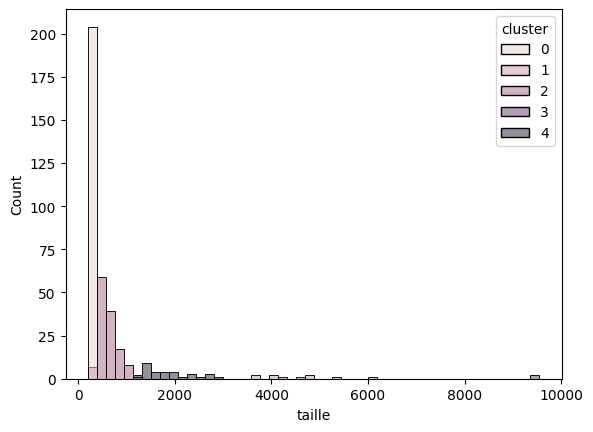

In [20]:
sns.histplot(data=df[df['taille'] > limit],x='taille',bins=50,hue='cluster')

In [ ]:
from PIL import Image
all_files = [f for f in os.listdir(train_normal_path) if os.path.isfile(os.path.join(train_normal_path, f))]
all_files.remove('all_tiles_coordinates.csv')

R = []
G = []
B = []

for file in all_file:
    filepath = f"{train_normal_path}/{file}"
    image = Image.open(filepath)
    img1 = np.array(image)
    R.append(img1[:,:,0].mean())
    G.append(img1[:,:,1].mean())
    B.append(img1[:,:,2].mean())

np.mean(R), np.mean(G), np.mean(B)

In [77]:
np.mean(R), np.mean(G), np.mean(B)

(235.53631171503582, 195.19794998341754, 223.91846553245398)

In [67]:
img1[:,:,0].mean(), img1[:,:,1].mean(), img1[:,:,2].mean(), img1[:,:,3].mean()

(225.51340103149414, 180.5108460187912, 225.5694499015808, 255.0)

In [ ]:
file_moved = move_unselected_files(train_tumor_path,selected_files)a

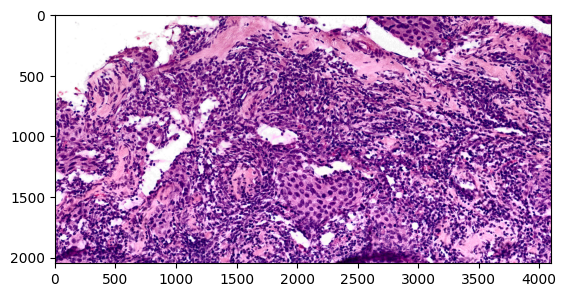

In [13]:
plt.imshow(image_fin)

True

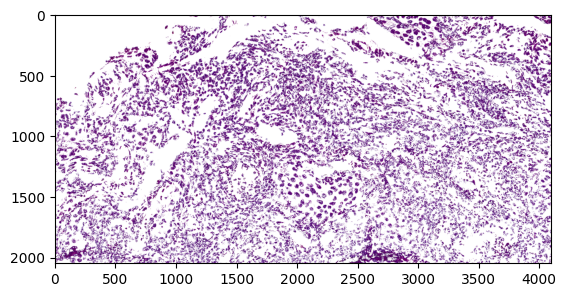

In [46]:
target_color = [50,  0, 50]
tolerance = 90
result = image_fin.copy()
mask = (
            (np.abs(image_fin[:,:,0] - target_color[0]) <= tolerance) &
            (np.abs(image_fin[:,:,1] - target_color[1]) <= tolerance) &
            (np.abs(image_fin[:,:,2] - target_color[2]) <= tolerance)
        )
# Mettre à zéro les pixels qui ne correspondent pas à la couleur cible
# Mais conserver le canal alpha original
result[~mask, 0:3] = 255

plt.imshow(result)
cv2.imwrite("resultat_rgba_filtre.jpg", result)